In [2]:
import sys
import os
sys.path.append('c:\\Users\\nkwan\\Desktop\\school\\capstone\\code\\legume')

In [3]:
import numpy as np
import legume
import chickpea
from chickpea.cma import CavityModeAnalysis
import matplotlib.pyplot as plt
import time

%load_ext autoreload
%autoreload 2

# Mode Volume and Normalization

Another important factor in the performance of a photonic crystal cavity is its mode volume.
The `CavityModeAnalysis` object provides a method for finding the mode volume.

It is worth investigating how this method is implemented and why this implementation is neccessary.

To see how this is used, we initialize an H2 crystal, as before.

In [4]:
Nx, Ny = 16, 16

#we can modify this to suit our needs
thickness = 0.71
eps = 11.56
rad = 0.37
cavType = 'H'
n = 2

crystal = chickpea.PhotonicCrystalCavity(crystal = cavType, n=n, supercell_size = (Nx, Ny),
                                         thickness = thickness, radius = rad, eps = eps)
phc = crystal.cavity()
base = crystal.get_base_crystal()

In [5]:
defectMargins = np.array([0.25, 0.25])
cma = CavityModeAnalysis(phc, base, defectMargins, layer=0, gmax=2, base_gmax=3)
#using this method places some constraints on the parameters

In [6]:
# find bandgaps to target solver
bandgaps, k_air, k_eps = cma.find_band_gaps(band_tol = 0.1, order=np.array([0]), trim_lc = True,
                                            lc_trim = 0.04, numeig=10)

options = {'verbose': True,
           'gmode_inds': [0],
           'gradients': 'approx',
           'eig_solver': 'eigh',
           'numeig': 50,
           'eig_sigma': bandgaps[0][2], # target center of bandgap
           'compute_im': False
}
kpoints = np.array([[k_air[0][0]], [k_air[1][0]]])
cma.gme.run(kpoints=kpoints, **options)

69.7032s total time for real part of frequencies, of which
  0.3340s for guided modes computation using the gmode_compute='exact' method
  1.4840s for inverse matrix of Fourier-space permittivity
  58.0117s for matrix diagionalization using the 'eigh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes


Below is the general algorithm used by cma to calculate mode volume.

In [7]:
def mode_volume(gme, dslab, field, components, kind, mind, l_x, l_y, marg_x, marg_y, sample_scale=2):
    """
    Get the Max
    """
    s_nx = int(sample_scale * l_x)
    s_ny = int(sample_scale * l_y)

    fields, _, _ = gme.get_field_xy(field=field, kind=kind, mind=mind, z=dslab / 2, component=components, Nx=s_nx, Ny=s_ny)

    field = np.zeros((s_ny, s_nx))
    for component in components:
        field = field + np.abs(fields[component]) ** 2

    field = field ** (1 / 2)

    defect_field = np.abs(field[int(marg_y * s_ny): -int(marg_y * s_ny),
                              int(marg_x * s_nx): -int(marg_x * s_nx)])

    mode_volume = 1 / np.square(np.amax(defect_field))

    return mode_volume

The mode volume is defined:

$$ \frac{\int \epsilon|\vec{E}|^2\ d{V}}{\text{max}(\epsilon |\vec{E}|^2)}$$

Note that the guided mode expansion stores fourier coefficients of the electromagnetic field as a vector.
When calculating the electromagnetic field at a point, we must do a fourier series over these coefficients.

However, as the fourier transform is unitary the norm squared of the eigenvector corresponds to the integral above.
By default, stored eigenvectors are normalized to 1.

Thus, to get a reasonable estimate for mode volume we need only calculate the maximum.
Doing so requires sampling the desired field in the region of the defect.

If the sample scale is too low it may miss the peaks of the field entirely.

The number of sample points as calculated by the `CavityModeAnalysis` object is the `sample_scale` multiplied
by the number of periods of the base crystal in the x and y directions. Thus, a sample scale of 1 will sample
at roughly every hole.

For monopole modes a very low sample scale is sufficient, we only need to sample the center.
For other modes we find a sample scale of 2 is sufficient and reasonably fast.

In [8]:
ss_low = 0.5
ss_high = 3
ss_step = 0.05
sample_scales = np.arange(ss_low, ss_high, ss_step)

The mode at index 13 is an interesting mode from the perspective of calculating mode volume,
as the field is localized in a ring around the defect region. Let's visualize that mode:

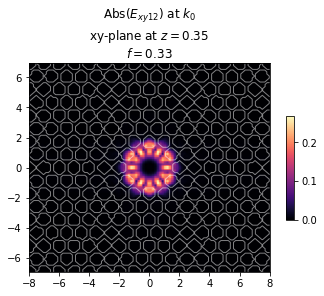

In [9]:
kind_nm = 0
mind_nm = 12

fig=legume.viz.field(cma.gme,'E', kind_nm, mind_nm, z=thickness/2, component='xy',
                     val='abs', N1=100, N2=100, norm=True)

Clearly this is a localized mode, let's see what mode volume is calculated for difference sample scales.

In [23]:
volumes = []
for ss in sample_scales:
    vol = cma.mode_volume(field='E', components='xy', kind = kind_nm, mind = mind_nm, sample_scale=ss)
    volumes.append(vol)

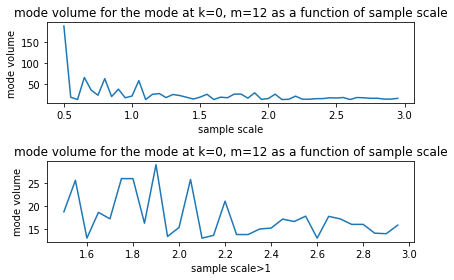

In [25]:
fig, ax = plt.subplots(2,1)

ax[0].plot(sample_scales, volumes)
ax[0].set_xlabel('sample scale')
ax[0].set_ylabel('mode volume')
ax[0].set_title('mode volume for the mode at k='+ str(kind_nm)+ ', m=' + str(mind_nm) + ' as a function of sample scale')

ax[1].plot(sample_scales[20:], volumes[20:])
ax[1].set_xlabel('sample scale>1')
ax[1].set_ylabel('mode volume')
ax[1].set_title('mode volume for the mode at k='+ str(kind_nm)+ ', m=' + str(mind_nm) + ' as a function of sample scale')
fig.tight_layout()

We see massive variability for low sample rates. Above 1 we still see variability, but we can make order of
magnitude estimates for mode volume. This is generally enough to differentiate localized modes from unlocalized modes
but should not be taken as a figure of merit unless one has knowledge that the peak of the field is being
sampled appropriately.

Let us calculate the mode volume for a large sample rate (the actual mode volume of the crystal)

In [14]:
vol_conv=cma.mode_volume(field='E', components='xy',
                                             kind = kind_nm, mind = mind_nm,
                                             sample_scale=20)
print('Actualy Mode Volume: %f' % vol_conv)

Mode Volume ss=15: 13.156661
